In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_csv('preprocessed_data.csv', index_col='dteday')
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,winter,2011,1,0,No,Saturday,No,clear,0.24,0.2879,81.0,0.0,3,13,16
2011-01-01,winter,2011,1,1,No,Saturday,No,clear,0.22,0.2727,80.0,0.0,8,32,40
2011-01-01,winter,2011,1,2,No,Saturday,No,clear,0.22,0.2727,80.0,0.0,5,27,32
2011-01-01,winter,2011,1,3,No,Saturday,No,clear,0.24,0.2879,75.0,0.0,3,10,13
2011-01-01,winter,2011,1,4,No,Saturday,No,clear,0.24,0.2879,75.0,0.0,0,1,1


In [24]:
df.drop(columns=['yr', 'mnth', 'hr'], axis=1, inplace=True)

- There is no Extreme Outliers in the data.

In [ ]:
df.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))
plt.show()

- Checking Columns with high and low Cardinality:
    - There is no columns with low or high cardinality

In [25]:
for col in df.select_dtypes(include='object').columns:
    print(col, df[col].nunique())

season 4
holiday 2
weekday 7
workingday 2
weathersit 4


In [32]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
# import plotly.express as px
from IPython.display import VimeoVideo
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

In [1]:
target = "casual"
y = df[target]
X = df.drop(target, axis=1)

NameError: name 'df' is not defined

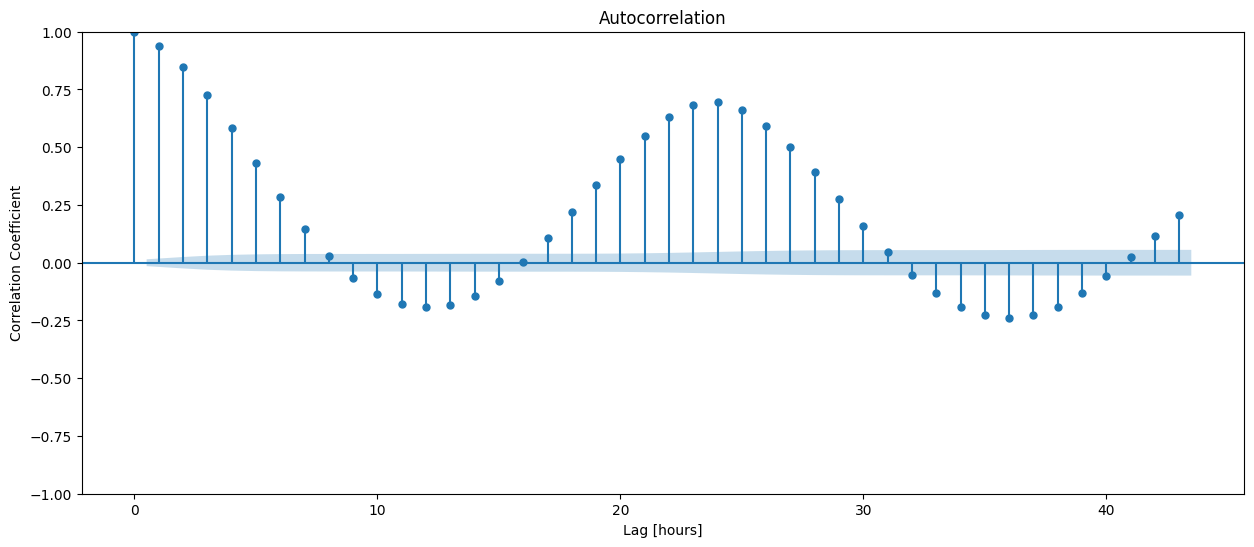

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [28]:
cutoff = int(len(df) * 0.8)

X_train, y_train = X[:cutoff], y[:cutoff]
X_test, y_test = X[cutoff:], y[cutoff:]

In [30]:
y_pred_baseline = [y_train.mean()] * len(X_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Casual Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Casual Reading: 34.04
Baseline MAE: 32.74


In [ ]:
make

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'winter'

In [ ]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

In [ ]:
intercept = model.intercept_
coefficient = model.coef_[0].round(2)

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

In [ ]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }
)
df_pred_test.head()

In [ ]:
fig = px.line(df_pred_test, labels={'value': 'P2'})
fig.show()